<h1 id = "sec_batch_norm">Batch Normalization</h1>

Training deep neural networks is difficult.
Getting them to converge in a reasonable amount of time can be tricky.
In this section, we describe *batch normalization*, a popular and effective technique
that consistently accelerates the convergence of deep networks :cite:`Ioffe.Szegedy.2015`.
Together with residual blocks covered later in :numref:`sec_resnet`---batch normalization
has made it possible for practitioners to routinely train networks with over 100 layers.
A secondary (serendipitous) benefit of batch normalization lies in its inherent regularization.


In [1]:
using Pkg; Pkg.activate("../../d2lai")
using d2lai
using Flux 
using CUDA, cuDNN
using Statistics, Flux.Zygote
CUDA.allowscalar(false)

  Activating project at `/workspace/d2l-julia/d2lai`


## Training Deep Networks

When working with data, we often preprocess before training.
Choices regarding data preprocessing often make an enormous difference in the final results.
Recall our application of MLPs to predicting house prices (:numref:`sec_kaggle_house`).
Our first step when working with real data
was to standardize our input features to have
zero mean $\boldsymbol{\mu} = 0$ and unit variance $\boldsymbol{\Sigma} = \boldsymbol{1}$ across multiple observations :cite:`friedman1987exploratory`, frequently rescaling the latter so  that the diagonal is unity, i.e., $\Sigma_{ii} = 1$.
Yet another strategy is to rescale vectors to unit length, possibly zero mean *per observation*.
This can work well, e.g., for spatial sensor data. These preprocessing techniques and many others, are
beneficial for keeping the estimation problem well controlled. 
For a review of feature selection and extraction see the article of :citet:`guyon2008feature`, for example.
Standardizing vectors also has the nice side-effect of constraining the function complexity of functions that act upon it. For instance, the celebrated radius-margin bound :cite:`Vapnik95` in support vector machines and the Perceptron Convergence Theorem :cite:`Novikoff62` rely on inputs of bounded norm. 

Intuitively, this standardization plays nicely with our optimizers
since it puts the parameters *a priori* on a similar scale.
As such, it is only natural to ask whether a corresponding normalization step *inside* a deep network
might not be beneficial. While this is not quite the reasoning that led to the invention of batch normalization :cite:`Ioffe.Szegedy.2015`, it is a useful way of understanding it and its cousin, layer normalization :cite:`Ba.Kiros.Hinton.2016`, within a unified framework.

Second, for a typical MLP or CNN, as we train,
the variables 
in intermediate layers (e.g., affine transformation outputs in MLP)
may take values with widely varying magnitudes:
whether along the layers from input to output, across units in the same layer,
and over time due to our updates to the model parameters.
The inventors of batch normalization postulated informally
that this drift in the distribution of such variables could hamper the convergence of the network.
Intuitively, we might conjecture that if one
layer has variable activations that are 100 times that of another layer,
this might necessitate compensatory adjustments in the learning rates. Adaptive solvers
such as AdaGrad :cite:`Duchi.Hazan.Singer.2011`, Adam :cite:`Kingma.Ba.2014`, Yogi :cite:`Zaheer.Reddi.Sachan.ea.2018`, or Distributed Shampoo :cite:`anil2020scalable` aim to address this from the viewpoint of optimization, e.g., by adding aspects of second-order methods. 
The alternative is to prevent the problem from occurring, simply by adaptive normalization.

Third, deeper networks are complex and tend to be more liable to overfitting.
This means that regularization becomes more critical. A common technique for regularization is noise
injection. This has been known for a long time, e.g., with regard to noise injection for the
inputs :cite:`Bishop.1995`. It also forms the basis of dropout in :numref:`sec_dropout`. As it turns out, quite serendipitously, batch normalization conveys all three benefits: preprocessing, numerical stability, and regularization.

Batch normalization is applied to individual layers, or optionally, to all of them:
In each training iteration,
we first normalize the inputs (of batch normalization)
by subtracting their mean and
dividing by their standard deviation,
where both are estimated based on the statistics of the current minibatch.
Next, we apply a scale coefficient and an offset to recover the lost degrees
of freedom. It is precisely due to this *normalization* based on *batch* statistics
that *batch normalization* derives its name.

Note that if we tried to apply batch normalization with minibatches of size 1,
we would not be able to learn anything.
That is because after subtracting the means,
each hidden unit would take value 0.
As you might guess, since we are devoting a whole section to batch normalization,
with large enough minibatches the approach proves effective and stable.
One takeaway here is that when applying batch normalization,
the choice of batch size is
even more significant than without batch normalization, or at least,
suitable calibration is needed as we might adjust batch size.

Denote by $\mathcal{B}$ a minibatch and let $\mathbf{x} \in \mathcal{B}$ be an input to 
batch normalization ($\textrm{BN}$). In this case the batch normalization is defined as follows:

$$\textrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}.$$
:eqlabel:`eq_batchnorm`

In :eqref:`eq_batchnorm`,
$\hat{\boldsymbol{\mu}}_\mathcal{B}$ is the  sample mean
and $\hat{\boldsymbol{\sigma}}_\mathcal{B}$ is the sample standard deviation of the minibatch $\mathcal{B}$.
After applying standardization,
the resulting minibatch
has zero mean and unit variance.
The choice of unit variance
(rather than some other magic number) is arbitrary. We recover this degree of freedom
by including an elementwise
*scale parameter* $\boldsymbol{\gamma}$ and *shift parameter* $\boldsymbol{\beta}$
that have the same shape as $\mathbf{x}$. Both are parameters that
need to be learned as part of model training.

The variable magnitudes
for intermediate layers cannot diverge during training
since batch normalization actively centers and rescales them back
to a given mean and size (via $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$).
Practical experience confirms that, as alluded to when discussing feature rescaling, batch normalization seems to allow for more aggressive learning rates.
We calculate $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ in :eqref:`eq_batchnorm` as follows:

$$\hat{\boldsymbol{\mu}}_\mathcal{B} = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x}
\textrm{ and }
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.$$

Note that we add a small constant $\epsilon > 0$
to the variance estimate
to ensure that we never attempt division by zero,
even in cases where the empirical variance estimate might be very small or vanish.
The estimates $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ counteract the scaling issue
by using noisy estimates of mean and variance.
You might think that this noisiness should be a problem.
On the contrary, it is actually beneficial.

This turns out to be a recurring theme in deep learning.
For reasons that are not yet well-characterized theoretically,
various sources of noise in optimization
often lead to faster training and less overfitting:
this variation appears to act as a form of regularization.
:citet:`Teye.Azizpour.Smith.2018` and :citet:`Luo.Wang.Shao.ea.2018`
related the properties of batch normalization to Bayesian priors and penalties, respectively. 
In particular, this sheds some light on the puzzle
of why batch normalization works best for moderate minibatch sizes in the 50--100 range.
This particular size of minibatch seems to inject just the "right amount" of noise per layer, both in terms of scale via $\hat{\boldsymbol{\sigma}}$, and in terms of offset via $\hat{\boldsymbol{\mu}}$: a
larger minibatch regularizes less due to the more stable estimates, whereas tiny minibatches
destroy useful signal due to high variance. Exploring this direction further, considering alternative types
of preprocessing and filtering may yet lead to other effective types of regularization.

Fixing a trained model, you might think
that we would prefer using the entire dataset
to estimate the mean and variance.
Once training is complete, why would we want
the same image to be classified differently,
depending on the batch in which it happens to reside?
During training, such exact calculation is infeasible
because the intermediate variables
for all data examples
change every time we update our model.
However, once the model is trained,
we can calculate the means and variances
of each layer's variables based on the entire dataset.
Indeed this is standard practice for
models employing batch normalization;
thus batch normalization layers function differently
in *training mode* (normalizing by minibatch statistics)
than in *prediction mode* (normalizing by dataset statistics).
In this form they closely resemble the behavior of dropout regularization of :numref:`sec_dropout`,
where noise is only injected during training.


## Batch Normalization Layers

Batch normalization implementations for fully connected layers
and convolutional layers are slightly different.
One key difference between batch normalization and other layers
is that because the former operates on a full minibatch at a time,
we cannot just ignore the batch dimension
as we did before when introducing other layers.

### Fully Connected Layers

When applying batch normalization to fully connected layers,
:citet:`Ioffe.Szegedy.2015`, in their original paper inserted batch normalization after the affine transformation
and *before* the nonlinear activation function. Later applications experimented with
inserting batch normalization right *after* activation functions.
Denoting the input to the fully connected layer by $\mathbf{x}$,
the affine transformation
by $\mathbf{W}\mathbf{x} + \mathbf{b}$ (with the weight parameter $\mathbf{W}$ and the bias parameter $\mathbf{b}$),
and the activation function by $\phi$,
we can express the computation of a batch-normalization-enabled,
fully connected layer output $\mathbf{h}$ as follows:

$$\mathbf{h} = \phi(\textrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).$$

Recall that mean and variance are computed
on the *same* minibatch
on which the transformation is applied.

### Convolutional Layers

Similarly, with convolutional layers,
we can apply batch normalization after the convolution
but before the nonlinear activation function. The key difference from batch normalization
in fully connected layers is that we apply the operation on a per-channel basis
*across all locations*. This is compatible with our assumption of translation
invariance that led to convolutions: we assumed that the specific location of a pattern
within an image was not critical for the purpose of understanding.

Assume that our minibatches contain $m$ examples
and that for each channel,
the output of the convolution has height $p$ and width $q$.
For convolutional layers, we carry out each batch normalization
over the $m \cdot p \cdot q$ elements per output channel simultaneously.
Thus, we collect the values over all spatial locations
when computing the mean and variance
and consequently
apply the same mean and variance
within a given channel
to normalize the value at each spatial location.
Each channel has its own scale and shift parameters,
both of which are scalars.

### Layer Normalization
:label:`subsec_layer-normalization-in-bn`

Note that in the context of convolutions the batch normalization is well defined even for
minibatches of size 1: after all, we have all the locations across an image to average. Consequently,
mean and variance are well defined, even if it is just within a single observation. This consideration
led :citet:`Ba.Kiros.Hinton.2016` to introduce the notion of *layer normalization*. It works just like
a batch norm, only that it is applied to one observation at a time. Consequently both the offset and the scaling factor are scalars. For an $n$-dimensional vector $\mathbf{x}$, layer norms are given by 

$$\mathbf{x} \rightarrow \textrm{LN}(\mathbf{x}) =  \frac{\mathbf{x} - \hat{\mu}}{\hat\sigma},$$

where scaling and offset are applied coefficient-wise
and given by 

$$\hat{\mu} \stackrel{\textrm{def}}{=} \frac{1}{n} \sum_{i=1}^n x_i \textrm{ and }
\hat{\sigma}^2 \stackrel{\textrm{def}}{=} \frac{1}{n} \sum_{i=1}^n (x_i - \hat{\mu})^2 + \epsilon.$$

As before we add a small offset $\epsilon > 0$ to prevent division by zero. One of the major benefits of using layer normalization is that it prevents divergence. After all, ignoring $\epsilon$, the output of the layer normalization is scale independent. That is, we have $\textrm{LN}(\mathbf{x}) \approx \textrm{LN}(\alpha \mathbf{x})$ for any choice of $\alpha \neq 0$. This becomes an equality for $|\alpha| \to \infty$ (the approximate equality is due to the offset $\epsilon$ for the variance). 

Another advantage of the layer normalization is that it does not depend on the minibatch size. It is also independent of whether we are in training or test regime. In other words, it is simply a deterministic transformation that standardizes the activations to a given scale. This can be very beneficial in preventing divergence in optimization. We skip further details and recommend that interested readers consult the original paper.

### Batch Normalization During Prediction

As we mentioned earlier, batch normalization typically behaves differently
in training mode than in prediction mode.
First, the noise in the sample mean and the sample variance
arising from estimating each on minibatches
is no longer desirable once we have trained the model.
Second, we might not have the luxury
of computing per-batch normalization statistics.
For example,
we might need to apply our model to make one prediction at a time.

Typically, after training, we use the entire dataset
to compute stable estimates of the variable statistics
and then fix them at prediction time.
Hence, batch normalization behaves differently during training than at test time.
Recall that dropout also exhibits this characteristic.

## **Implementation from Scratch**

To see how batch normalization works in practice, we implement one from scratch below.


In [2]:
function batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum, train_mode = true)
    if train_mode == false
        return (X - moving_mean) / (sqrt(moving_var) + eps)
    else 
        # @assert ndims(X) in (2, 4)
        mean_, var_ = if ndims(X) == 2
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean_ = mean(X, dims = 2)
            var_ = var(X, dims = 2)
            
            mean_, var_
        else
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=3). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean_ = mean(X, dims = (1, 2, 4))
            var_= var(X, dims = (1, 2, 4))
            mean_, var_
        end
        X_hat = (X .- mean_) ./ (sqrt.(var_) .+ eps)
        Zygote.ignore() do
            moving_mean = (1.0 - momentum) .* moving_mean .+ momentum .* mean_
            moving_var = (1.0 - momentum) .* moving_var .+ momentum .* var_
        end
        Y = gamma .* X_hat .+ beta  # Scale and shift
        return Y, moving_mean, moving_var
    end
end

batch_norm (generic function with 2 methods)

We can now **create a proper `BatchNorm` layer.**
Our layer will maintain proper parameters
for scale `gamma` and shift `beta`,
both of which will be updated in the course of training.
Additionally, our layer will maintain
moving averages of the means and variances
for subsequent use during model prediction.

Putting aside the algorithmic details,
note the design pattern underlying our implementation of the layer.
Typically, we define the mathematics in a separate function, say `batch_norm`.
We then integrate this functionality into a custom layer,
whose code mostly addresses bookkeeping matters,
such as moving data to the right device context,
allocating and initializing any required variables,
keeping track of moving averages (here for mean and variance), and so on.
This pattern enables a clean separation of mathematics from boilerplate code.
Also note that for the sake of convenience
we did not worry about automatically inferring the input shape here;
thus we need to specify the number of features throughout.
By now all modern deep learning frameworks offer automatic detection of size and shape in the
high-level batch normalization APIs (in practice we will use this instead).

In [37]:
mutable struct BatchNormLayer{G, B, M, V}
    gamma::G
    beta::B
    moving_mean::M
    moving_var::V
    training_mode::Bool
end

function BatchNormLayer(num_features, num_dims)
    shape = if num_dims == 2
        (num_features, 1)
    else
        # h x w x ch x batch
        (1, 1, num_features, 1)
    end
    gamma = ones(Float32, shape)
    beta = zeros(Float32, shape)

    moving_mean = zeros(Float32, shape)
    moving_var = ones(Float32, shape)
    BatchNormLayer(gamma, beta, moving_mean, moving_var, true)
end

function (b::BatchNormLayer)(x)
    Y, moving_mean, moving_var = batch_norm(x, b.gamma, b.beta, b.moving_mean, b.moving_var, 1e-5, 0.1, b.training_mode)
    Zygote.ignore() do
        b.moving_mean = moving_mean
        b.moving_var = moving_var
    end
    return Y
end

Flux.@layer BatchNormLayer 

Flux.Optimisers.trainable(b::BatchNormLayer) = (; gamma = b.gamma, beta = b.beta)

We used `momentum` to govern the aggregation over past mean and variance estimates. This is somewhat of a misnomer as it has nothing whatsoever to do with the *momentum* term of optimization. Nonetheless, it is the commonly adopted name for this term and in deference to API naming convention we use the same variable name in our code.

## **LeNet with Batch Normalization**

To see how to apply `BatchNorm` in context,
below we apply it to a traditional LeNet model (:numref:`sec_lenet`).
Recall that batch normalization is applied
after the convolutional layers or fully connected layers
but before the corresponding activation functions.

In [36]:
struct BLeNetScratch{N} <: AbstractClassifier 
    net::N
end

function BLeNetScratch(num_classes::Int = 10)
    net = Flux.@autosize (28,28,1,1)  Chain(
        Conv((5,5), 1=>6), BatchNormLayer(6, 4),
        x -> sigmoid.(x), 
        Conv((2,2), 6=>6, stride = 2),
        Conv((5,5), 6 => 16), 
        BatchNormLayer(16, 4),
        x -> sigmoid.(x),
        Conv((2,2), 16=> 16, stride = 2),
        Flux.flatten,
        Dense(_ => 120),
        BatchNormLayer(120, 2), x -> sigmoid.(x),
        Dense(120, 84),
        BatchNormLayer(84, 2), x -> sigmoid.(x),
        Dense(84 => num_classes),
        softmax
    )
    BLeNetScratch(net)
end

Flux.@layer BLeNetScratch

(b::BLeNetScratch)(x) = b.net(x)

As before, we will **train our network on the Fashion-MNIST dataset**.
This code is virtually identical to that when we first trained LeNet.

[ Info: Train Loss: 0.4631312, Val Loss: 0.3192523, Val Acc: 0.9375
[ Info: Train Loss: 0.37025794, Val Loss: 0.26219362, Val Acc: 0.875
[ Info: Train Loss: 0.36113393, Val Loss: 0.20156513, Val Acc: 0.9375
[ Info: Train Loss: 0.3156085, Val Loss: 0.15843813, Val Acc: 1.0
[ Info: Train Loss: 0.3402258, Val Loss: 0.32072288, Val Acc: 0.9375
[ Info: Train Loss: 0.2883389, Val Loss: 0.1670382, Val Acc: 1.0
[ Info: Train Loss: 0.28461364, Val Loss: 0.14621627, Val Acc: 1.0
[ Info: Train Loss: 0.2441345, Val Loss: 0.17458619, Val Acc: 1.0
[ Info: Train Loss: 0.18341242, Val Loss: 0.17007804, Val Acc: 1.0
[ Info: Train Loss: 0.16129655, Val Loss: 0.18824415, Val Acc: 1.0


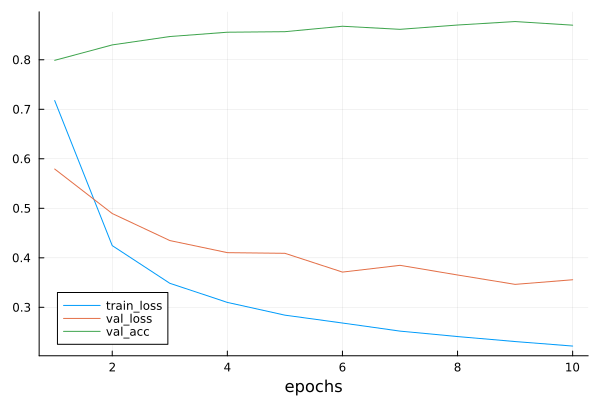

In [27]:
model = BLeNetScratch() 
data = d2lai.FashionMNISTData(batchsize = 128)
opt = Descent(0.1)
trainer = Trainer(model, data, opt; max_epochs = 10, gpu = true, board_yscale = :identity)
d2lai.fit(trainer);

Let's **have a look at the scale parameter `gamma`
and the shift parameter `beta`** learned
from the first batch normalization layer.


## **Concise Implementation**

Compared with the `BatchNorm` class,
which we just defined ourselves,
we can use the `BatchNorm` class defined in high-level APIs from the deep learning framework directly.
The code looks virtually identical
to our implementation above, except that we no longer need to provide additional arguments for it to get the dimensions right.


In [17]:
struct BLeNetConcise{N} <: AbstractClassifier 
    net::N
end

function BLeNetConcise(num_classes::Int = 10)
    net = Flux.@autosize (28, 28, 1, 1) Chain(
        Conv((5,5), 1=>6), BatchNorm(6, sigmoid),
        MaxPool((2,2), stride = 2),
        Conv((5,5), 6 => 16), BatchNorm(16, sigmoid),
        MaxPool((2,2), stride = 2),
        Flux.flatten,
        Dense(_ => 120),
        BatchNorm(120, sigmoid), 
        Dense(120, 84),
        BatchNorm(84, sigmoid), 
        Dense(84 => num_classes),
        softmax
    )
    BLeNetConcise(net)
end

Flux.@layer BLeNetConcise

(b::BLeNetConcise)(x) = b.net(x)

[ Info: Train Loss: 0.45143667, Val Loss: 0.45176387, Val Acc: 0.8125
[ Info: Train Loss: 0.41508856, Val Loss: 0.6085408, Val Acc: 0.75
[ Info: Train Loss: 0.3806695, Val Loss: 0.41424468, Val Acc: 0.875
[ Info: Train Loss: 0.2128005, Val Loss: 0.3537377, Val Acc: 0.8125
[ Info: Train Loss: 0.4056586, Val Loss: 0.2893559, Val Acc: 0.9375
[ Info: Train Loss: 0.26684073, Val Loss: 0.25370955, Val Acc: 0.9375
[ Info: Train Loss: 0.33146727, Val Loss: 0.3267294, Val Acc: 0.8125
[ Info: Train Loss: 0.27326724, Val Loss: 0.24755274, Val Acc: 0.875
[ Info: Train Loss: 0.16213961, Val Loss: 0.1878311, Val Acc: 1.0
[ Info: Train Loss: 0.17959578, Val Loss: 0.25928864, Val Acc: 0.9375


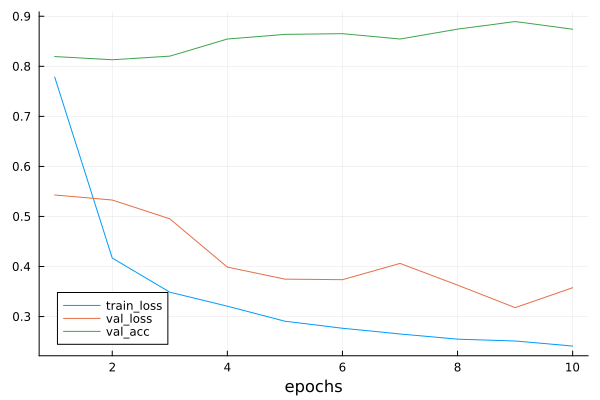

In [18]:
model = BLeNetConcise()
data = d2lai.FashionMNISTData(batchsize = 128)
opt = Descent(0.1) 
trainer = Trainer(model, data, opt; max_epochs = 10, gpu = true, board_yscale = :identity)
d2lai.fit(trainer);

## Discussion

Intuitively, batch normalization is thought
to make the optimization landscape smoother.
However, we must be careful to distinguish between
speculative intuitions and true explanations
for the phenomena that we observe when training deep models.
Recall that we do not even know why simpler
deep neural networks (MLPs and conventional CNNs)
generalize well in the first place.
Even with dropout and weight decay,
they remain so flexible that their ability to generalize to unseen data
likely needs significantly more refined learning-theoretic generalization guarantees.

The original paper proposing batch normalization :cite:`Ioffe.Szegedy.2015`, in addition to introducing a powerful and useful tool,
offered an explanation for why it works:
by reducing *internal covariate shift*.
Presumably by *internal covariate shift* they
meant something like the intuition expressed above---the
notion that the distribution of variable values changes
over the course of training.
However, there were two problems with this explanation:
i) This drift is very different from *covariate shift*,
rendering the name a misnomer. If anything, it is closer to concept drift. 
ii) The explanation offers an under-specified intuition
but leaves the question of *why precisely this technique works*
an open question wanting for a rigorous explanation.
Throughout this book, we aim to convey the intuitions that practitioners
use to guide their development of deep neural networks.
However, we believe that it is important
to separate these guiding intuitions
from established scientific fact.
Eventually, when you master this material
and start writing your own research papers
you will want to be clear to delineate
between technical claims and hunches.

Following the success of batch normalization,
its explanation in terms of *internal covariate shift*
has repeatedly surfaced in debates in the technical literature
and broader discourse about how to present machine learning research.
In a memorable speech given while accepting a Test of Time Award
at the 2017 NeurIPS conference,
Ali Rahimi used *internal covariate shift*
as a focal point in an argument likening
the modern practice of deep learning to alchemy.
Subsequently, the example was revisited in detail
in a position paper outlining
troubling trends in machine learning :cite:`Lipton.Steinhardt.2018`.
Other authors
have proposed alternative explanations for the success of batch normalization,
some :cite:`Santurkar.Tsipras.Ilyas.ea.2018`
claiming that batch normalization's success comes despite exhibiting behavior
that is in some ways opposite to those claimed in the original paper.


We note that the *internal covariate shift*
is no more worthy of criticism than any of
thousands of similarly vague claims
made every year in the technical machine learning literature.
Likely, its resonance as a focal point of these debates
owes to its broad recognizability for the target audience.
Batch normalization has proven an indispensable method,
applied in nearly all deployed image classifiers,
earning the paper that introduced the technique
tens of thousands of citations. We conjecture, though, that the guiding principles
of regularization through noise injection, acceleration through rescaling and lastly preprocessing
may well lead to further inventions of layers and techniques in the future.

On a more practical note, there are a number of aspects worth remembering about batch normalization:

* During model training, batch normalization continuously adjusts the intermediate output of
  the network by utilizing the mean and standard deviation of the minibatch, so that the
  values of the intermediate output in each layer throughout the neural network are more stable.
* Batch normalization is slightly different for fully connected layers than for convolutional layers. In fact,
  for convolutional layers, layer normalization can sometimes be used as an alternative.
* Like a dropout layer, batch normalization layers have different behaviors
  in training mode than in prediction mode.
* Batch normalization is useful for regularization and improving convergence in optimization. By contrast,
  the original motivation of reducing internal covariate shift seems not to be a valid explanation.
* For more robust models that are less sensitive to input perturbations, consider removing batch normalization :cite:`wang2022removing`.

## Exercises

1. Should we remove the bias parameter from the fully connected layer or the convolutional layer before the batch normalization? Why?
1. Compare the learning rates for LeNet with and without batch normalization.
    1. Plot the increase in validation accuracy.
    1. How large can you make the learning rate before the optimization fails in both cases?
1. Do we need batch normalization in every layer? Experiment with it.
1. Implement a "lite" version of batch normalization that only removes the mean, or alternatively one that
   only removes the variance. How does it behave?
1. Fix the parameters `beta` and `gamma`. Observe and analyze the results.
1. Can you replace dropout by batch normalization? How does the behavior change?
1. Research ideas: think of other normalization transforms that you can apply:
    1. Can you apply the probability integral transform?
    1. Can you use a full-rank covariance estimate? Why should you probably not do that? 
    1. Can you use other compact matrix variants (block-diagonal, low-displacement rank, Monarch, etc.)?
    1. Does a sparsification compression act as a regularizer?
    1. Are there other projections (e.g., convex cone, symmetry group-specific transforms) that you can use?
### 1. 
Yes we can remove the bias term, since BatchNorm has a bias parameter that can be trained. 

### 2.

In [ ]:
using Random 
Random.seed!(1)

struct LeNet{N} <: AbstractClassifier
    net::N
end

function LeNet(; num_classes = 10, init = Flux.glorot_normal)
    net = Chain(
        Conv((5,5), 1 => 6, sigmoid; pad = 2, init = init),
        MeanPool((2,2), stride = 2),
        Conv((5,5), 6 => 16, sigmoid, init = init),
        MeanPool((2,2), stride = 2),
        Flux.flatten,
        Dense(400 => 120, sigmoid, init = init),
        Dense(120 => 84, sigmoid, init = init),
        Dense(84 => num_classes, init = init),
        Flux.softmax
    ) 
    LeNet(net)
end

Flux.@layer LeNet

lenet_metrics = []
blenet_metrics = []

for lr in (0.05, 0.1, 0.5, 0.75, 1.0)
    mlenet = LeNet()
    mblenet = BLeNetConcise()
    opt = Descent(lr) 
    trainer_mlenet = Trainer(mlenet, data, opt; max_epochs = 10, gpu = true, board_yscale = :identity)
    trainer_mblenet = Trainer(mblenet, data, opt; max_epochs = 10, gpu = true, board_yscale = :identity)
    metrics_mlenet = d2lai.fit(trainer_mlenet)
    metrics_mblenet = d2lai.fit(trainer_mblenet)
    push!(lenet_metrics, metrics_mlenet)
    push!(blenet_metrics, metrics_mblenet)
end

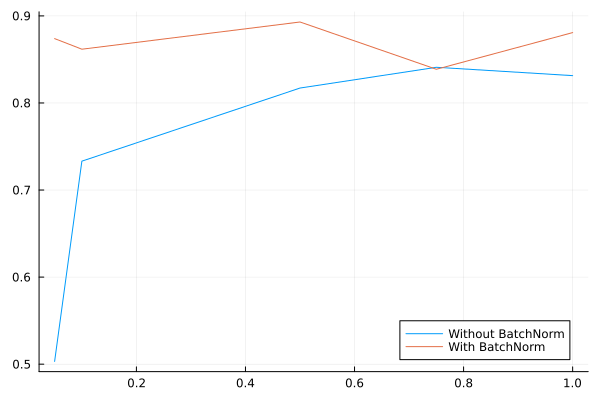

In [33]:
val_acc_lenet = mean.(getproperty.(last.(lenet_metrics), :val_acc))
val_acc_blenet = mean.(getproperty.(last.(blenet_metrics), :val_acc))
using Plots
plot([0.05, 0.1, 0.5, 0.75, 1.0], val_acc_lenet, label = "Without BatchNorm")
plot!([0.05, 0.1, 0.5, 0.75, 1.0], val_acc_blenet, label = "With BatchNorm")

### 3.
We can use BatchNorm in every layer as it can be helpful for regularization.
### 4.
As we can see, the model doesnot learn anything

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Conv((2, 2), 6 => 6, stride=2)  # 150 parameters
│   summary(x) = "24×24×6×128 CuArray{Float64, 4, CUDA.DeviceMemory}"
└ @ Flux ~/.julia/packages/Flux/Mhg1r/src/layers/stateless.jl:60
[ Info: Train Loss: 2.2824814, Val Loss: 2.2885203, Val Acc: 0.0625
[ Info: Train Loss: 2.2674475, Val Loss: 2.2789936, Val Acc: 0.1875
[ Info: Train Loss: 2.2900603, Val Loss: 2.3100336, Val Acc: 0.1875
[ Info: Train Loss: 2.2668967, Val Loss: 2.3106945, Val Acc: 0.0625
[ Info: Train Loss: 2.2902527, Val Loss: 2.2931676, Val Acc: 0.1875
[ Info: Train Loss: 2.281236, Val Loss: 2.3409395, Val Acc: 0.1875
[ Info: Train Loss: 2.274639, Val Loss: 2.3200262, Val Acc: 0.125
[ Info: Train Loss: 2.2713368, Val Loss: 2.3059773, Val Acc: 0.0625
[ Info: Train Loss: 2.2670038, Val Loss: 2.3461761, Val Acc: 0.0625
[ Info: Train Loss: 2.2866585, Val Loss: 2.304185, Val Acc: 0

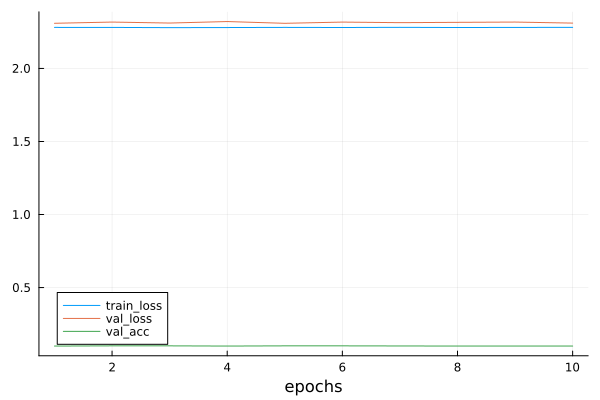

In [39]:
function batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum, train_mode = true)
    if train_mode == false
        return X ./ (sqrt.(moving_var) .+ eps)
    else 
        # @assert ndims(X) in (2, 4)
        var_ = if ndims(X) == 2
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            # mean_ = mean(X, dims = 2)
            var_ = var(X, dims = 2)
            
             var_
        else
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=3). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            var_= var(X, dims = (1, 2, 4))
            var_
        end
        X_hat = X ./ (sqrt.(var_) .+ eps)
        Zygote.ignore() do
            # moving_mean = (1.0 - momentum) .* moving_mean .+ momentum .* mean_
            moving_var = (1.0 - momentum) .* moving_var .+ momentum .* var_
        end
        Y = gamma .* X_hat .+ beta  # Scale and shift
        return Y, moving_mean, moving_var
    end
end

model = BLeNetScratch() 
data = d2lai.FashionMNISTData(batchsize = 128)
opt = Descent(0.1)
trainer = Trainer(model, data, opt; max_epochs = 10, gpu = true, board_yscale = :identity)
d2lai.fit(trainer);

[ Info: Train Loss: 2.219718, Val Loss: 2.2997036, Val Acc: 0.0625
[ Info: Train Loss: 1.7338852, Val Loss: 1.898788, Val Acc: 0.375
[ Info: Train Loss: 1.0146419, Val Loss: 0.8658886, Val Acc: 0.8125
[ Info: Train Loss: 0.7644134, Val Loss: 0.5105693, Val Acc: 0.875
[ Info: Train Loss: 0.44375074, Val Loss: 0.3874966, Val Acc: 0.9375
[ Info: Train Loss: 0.8035989, Val Loss: 0.48309743, Val Acc: 0.9375
[ Info: Train Loss: 0.5838441, Val Loss: 0.3401048, Val Acc: 0.9375
[ Info: Train Loss: 0.5341844, Val Loss: 0.31437856, Val Acc: 0.9375
[ Info: Train Loss: 0.43436804, Val Loss: 0.25882012, Val Acc: 0.9375
[ Info: Train Loss: 0.42694616, Val Loss: 0.22342739, Val Acc: 0.9375


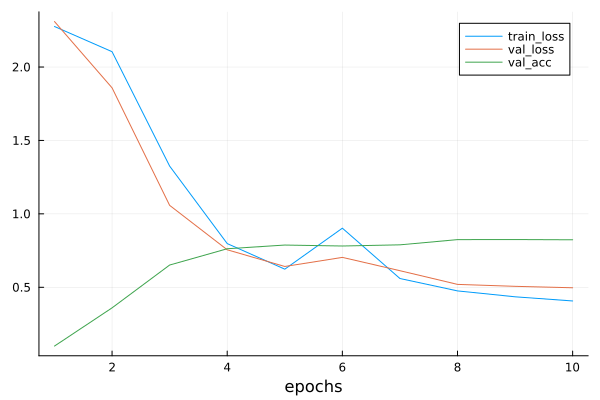

In [40]:
### 5.
function BatchNormLayer(num_features, num_dims)
    shape = if num_dims == 2
        (num_features, 1)
    else
        # h x w x ch x batch
        (1, 1, num_features, 1)
    end
    gamma = rand(Float32, shape)
    beta = rand(Float32, shape)

    moving_mean = zeros(Float32, shape)
    moving_var = ones(Float32, shape)
    BatchNormLayer(gamma, beta, moving_mean, moving_var, true)
end

Flux.Optimisers.trainable(::BatchNormLayer) = (;)
model = BLeNetScratch() 
data = d2lai.FashionMNISTData(batchsize = 128)
opt = Descent(0.1)
trainer = Trainer(model, data, opt; max_epochs = 10, gpu = true, board_yscale = :identity)
d2lai.fit(trainer);